# Classificazione ECG: punto3
In questa ultima parte del progetto abbiamo applicato regolarizzazioni L1 ed L2 per migliorare la rete e diminuire l'overfitting. Abbiamo considerato diversi valori dell'iperparametro $\lambda$ e valutato quale desse il risultato migliore.


Rifacciamo il download dei dati e il data augmentation.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential,utils, regularizers, initializers, optimizers
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, Softmax
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
from tensorflow import keras
import tensorflow as tf
import neurokit2 as nk

In [3]:
meta = pd.read_csv('/content/meta.csv', header = None, error_bad_lines=False)
meta = pd.DataFrame(meta)

Creiamo il vettore 'pazienti'

In [4]:
patients=[]
for i in range(294):
    if (i+1)!=124 and (i+1)!=132 and (i+1)!=134 and (i+1)!=161 and (i+1)!=139:
        patients.append(i+1)
patients=np.array(patients)

patient_new = []
for i in patients:
    if i < 10:
        p = 'patient00%i' % i
    elif i < 100 and i > 9:
        p = 'patient0%i' % i
    else:
        p = 'patient%i' % i
        
    for j in range(550):
        if p == meta.iloc[j][0]:
            if meta.iloc[j][13] == 'Myocardial infarction' or meta.iloc[j][13] == 'Healthy control':
                patient_new.append(i)
                break
                
patients = np.array(patient_new)                


In [6]:
num_battiti = []
X = []
for i in patients:
    if i < 10:
        file = 'ECG_lead2_patient00%i.npy' % i
    elif i < 100 and i > 9:
        file = 'ECG_lead2_patient0%i.npy' % i
    else:
        file = 'ECG_lead2_patient%i.npy' % i
    a = np.load(file, allow_pickle=True)
    c = 0
    for i in a:
        X.append(i)
        c+=1
    num_battiti.append(c)
    
num_battiti = np.array(num_battiti)
X = np.array(X)
print(num_battiti)

[153 151 135 155 124 149 101 114  19 166  35 125 169 154 128 109 121 133
 141 135 161 130 109 149 132 150 163  95 162 143 148 160 112 148 168 140
 132 114 154 139 165 134 157 121 163 145 126 128 139 126 128 150 155 132
 201 112 141 154 168 165 159 155 137 172 105 135 100 169 115 154 121 119
 120 136 149 167 202 158 128 161 153 110 120 116 138 168 176 177 140 119
 141 127 160 194 138 117 121 192 151 202 171 175 100 118 149  50  54 118
 132 145 165 127  41 197 141  57  55 152 164  44 156  57 129  44 149 133
 135  40  54 112 115 110 181 129 127 131 117 137  40 166 120 132  39 156
 118 118 136 139 211 196 141 119 121 117 147 122 108 134 123 122 157 161
 155 111 144 184 149 122 116 162 126 153 122 130 117 123 126 152 124 122
 145 110 134 138  87 110 153  98  92 124 122 103 142 180 121 140 219 143
 149]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
N = num_battiti.sum()
print(N)

n = np.arange(N)

import random
cut = int(0.85 * N) #85% del totale
random.shuffle(n)
X_train_index = n[:cut] # first 85% train
X_test_index = n[cut:] # last 15% test

cut1 = int(0.128 * len(X_train_index))
random.shuffle(X_train_index)
X_train_index = X_train_index[cut1:]
X_val_index = X_train_index[:cut1]

X_test_index = np.array(X_test_index)
X_train_index = np.array(X_train_index)
X_val_index = np.array(X_val_index)

26560


In [8]:
print(X_train_index.size)
print(X_test_index.size)
print(X_val_index.size)
print(X_train_index.size + X_test_index.size + X_val_index.size)

19687
3984
2889
26560


In [9]:
y_label = []
for i in patients:
    if i < 10:
        line = 'patient00%i' % i
    elif i < 100 and i > 9:
        line = 'patient0%i' % i
    else:
        line = 'patient%i' % i
    for i in range(1, 550):
        if meta.iloc[i][0] == line:
            if meta.iloc[i][13] == 'Myocardial infarction':
                if meta.iloc[i][14] == 'anterior':
                    label = 1
                elif meta.iloc[i][14] == 'infero-latera' or meta.iloc[i][14] == 'infero-lateral':
                    label = 2
                elif meta.iloc[i][14] == 'antero-lateral':
                    label = 3
                elif meta.iloc[i][14] == 'inferior':
                    label = 4
                elif meta.iloc[i][14] == 'antero-septal':
                    label = 5
                elif meta.iloc[i][14] == 'infero-posterior-lateral' or meta.iloc[i][14] == 'infero-postero-lateral' or meta.iloc[i][14] == 'infero-poster-lateral':
                    label = 6
                elif meta.iloc[i][14] == 'postero-lateral':
                    label = 7
                elif meta.iloc[i][14] == 'posterior':
                    label = 8
                elif meta.iloc[i][14] == 'lateral':
                    label = 9
                elif meta.iloc[i][14] == 'infero-posterior':
                    label = 10
                elif meta.iloc[i][14] == 'antero-septo-lateral':
                    label = 11
            elif meta.iloc[i][13] == 'Healthy control':
                label = 0
            y_label.append(label)
            break
            
y_label = np.array(y_label)
y_label.size

199

In [10]:
y_label_new = []
for i in range(y_label.size):
    for j in range(num_battiti[i]):
        y_label_new.append(y_label[i])
        
y_label = np.array(y_label_new)
y_label.size

26560

In [21]:
num_battiti_MI = np.zeros(294) # numero di battiti per ogni file dei pazienti con infarto del miocardio
X_MI = [] #ECG corrispondenti
for i in range(1, 550):
    p = int(meta.iloc[i][0].split('t')[2])
    file = 'ECG%i.npy' % i
    try:
        a = np.load(file, allow_pickle=True)
        c = 0
        for i in a:
            X_MI.append(i)
            c+=1
        num_battiti_MI[p-1] += c
    except:
        print('File does not exist')
    
num_battiti_MI = num_battiti_MI.astype(int)
X_MI = np.array(X_MI)
print(num_battiti_MI)
print(num_battiti_MI.size)

File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [22]:
X_total = np.concatenate((X, X_MI))
X_total.shape

(70412,)

In [23]:
y_label_MI = np.zeros(294)
for j in MI_MoreThanOne:
    if j < 10:
        line = 'patient00%i' % j
    elif j < 100 and i > 9:
        line = 'patient0%i' % j
    else:
        line = 'patient%i' % j
    for i in range(1, 550):
        if meta.iloc[i][0] == line:
            if meta.iloc[i][13] == 'Myocardial infarction':
                if meta.iloc[i][14] == 'anterior':
                    label = 1
                elif meta.iloc[i][14] == 'infero-latera' or meta.iloc[i][14] == 'infero-lateral':
                    label = 2
                elif meta.iloc[i][14] == 'antero-lateral':
                    label = 3
                elif meta.iloc[i][14] == 'inferior':
                    label = 4
                elif meta.iloc[i][14] == 'antero-septal':
                    label = 5
                elif meta.iloc[i][14] == 'infero-posterior-lateral' or meta.iloc[i][14] == 'infero-postero-lateral' or meta.iloc[i][14] == 'infero-poster-lateral':
                    label = 6
                elif meta.iloc[i][14] == 'postero-lateral':
                    label = 7
                elif meta.iloc[i][14] == 'posterior':
                    label = 8
                elif meta.iloc[i][14] == 'lateral':
                    label = 9
                elif meta.iloc[i][14] == 'infero-posterior':
                    label = 10
                elif meta.iloc[i][14] == 'antero-septo-lateral':
                    label = 11
            elif meta.iloc[i][13] == 'Healthy control':
                label = 0
            y_label_MI[j-1] += label
            break
            
y_label_MI = y_label_MI.astype(int)
y_label_MI.size

294

In [24]:
#togliamo gli zeri
y_label_new = []
num_battiti_new = []
for i in range(y_label_MI.size):
    if y_label_MI[i] != 0:
        y_label_new.append(y_label_MI[i])
        num_battiti_new.append(num_battiti_MI[i])
        
y_label_MI = np.array(y_label_new)
num_battiti_MI = np.array(num_battiti_new)
print(y_label_MI.size)
print(num_battiti_MI.size)

87
87


In [25]:
#creiamo il vettore di label per gli MI
y_label_new = []
for i in range(y_label_MI.size):
    for j in range(num_battiti_MI[i]):
        y_label_new.append(y_label_MI[i])
        
y_label_MI = np.array(y_label_new)
y_label_MI.size

43852

In [26]:
Y_total = np.concatenate((y_label, y_label_MI))

In [27]:
X_total_new = []
Y_total_new = []
for i in range(X_total.shape[0]):
    if X_total[i].size==650:
        X_total_new.append(X_total[i])
        Y_total_new.append(Y_total[i])
X_total = np.array(X_total_new)
Y_total = np.array(Y_total_new)
print(X_total.shape)
print(Y_total.size)

(70177, 650)
70177


In [28]:
N = X_total.shape[0]

n = np.arange(N)

import random
cut = int(0.85 * N) #85% del totale
random.shuffle(n)
X_train_index = n[:cut] # first 85% train
X_test_index = n[cut:] # last 15% test

cut1 = int(0.128 * len(X_train_index))
random.shuffle(X_train_index)
X_train_index = X_train_index[cut1:] # last 70% train
X_val_index = X_train_index[:cut1] # first 15% train

X_test_index = np.array(X_test_index)
X_train_index = np.array(X_train_index)
X_val_index = np.array(X_val_index)

In [29]:
print(X_train_index.size)
print(X_test_index.size)
print(X_val_index.size)
print(X_train_index.size + X_test_index.size + X_val_index.size)

52015
10527
7635
70177


In [30]:
Xtrain = []
Ytrain = []
Xval = []
Yval = []
Xtest = []
Ytest = []
for i in X_train_index:
    Xtrain.append(X_total[i])
    Ytrain.append(Y_total[i])
for i in X_test_index:
    Xtest.append(X_total[i])
    Ytest.append(Y_total[i])
for i in X_val_index:
    Xval.append(X_total[i])
    Yval.append(Y_total[i])
    
Xtrain = np.array(Xtrain, dtype=object)
Ytrain = np.array(Ytrain, dtype=object)
Xtest = np.array(Xtest, dtype=object)
Ytest = np.array(Ytest, dtype=object)
Xval = np.array(Xval, dtype=object)
Yval = np.array(Yval, dtype=object)

In [34]:
#Applico una maschera sui vettori X. Seleziono quelli con un determinato label
df_0  = Xtrain[Ytrain == 0]
df_1  = Xtrain[Ytrain == 1]
df_2  = Xtrain[Ytrain == 2]
df_3  = Xtrain[Ytrain == 3]
df_4  = Xtrain[Ytrain == 4]
df_5  = Xtrain[Ytrain == 5]
df_6  = Xtrain[Ytrain == 6]
df_7  = Xtrain[Ytrain == 7]
df_8  = Xtrain[Ytrain == 8]
df_9  = Xtrain[Ytrain == 9]
df_10 = Xtrain[Ytrain == 10]
df_11 = Xtrain[Ytrain == 11]

In [35]:
#data augmentation
from sklearn.utils import resample

df_0_upsample = resample(df_0, n_samples = 10000, replace = True, random_state = 123)
df_1_upsample = resample(df_1, n_samples = 10000, replace = True, random_state = 123)
df_2_upsample = resample(df_2, n_samples = 10000, replace = True, random_state = 123)
df_3_upsample = resample(df_3, n_samples = 10000, replace = True, random_state = 123)
df_6_upsample = resample(df_6, n_samples = 10000, replace = True, random_state = 123)
df_7_upsample = resample(df_7, n_samples = 10000, replace = True, random_state = 123)
df_8_upsample = resample(df_8, n_samples = 10000, replace = True, random_state = 123)
df_9_upsample = resample(df_9, n_samples = 10000, replace = True, random_state = 123)
df_10_upsample = resample(df_10, n_samples = 10000, replace = True, random_state = 123)
df_11_upsample = resample(df_11, n_samples = 10000, replace = True, random_state = 123)

In [36]:
df_4_downsample = resample(df_4, n_samples = 10000, replace = False, random_state = 123)
df_5_downsample = resample(df_5, n_samples = 10000, replace = False, random_state = 123)

In [37]:
train_df=np.concatenate((df_0_upsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_downsample, df_5_downsample, df_6_upsample, df_7_upsample, df_8_upsample, df_9_upsample, df_10_upsample, df_11_upsample))
Xtrain = train_df
Ytrain_df=[]
for h in range(12):
    for i in range(10000):
        Ytrain_df.append(h) 
        
Ytrain_df=np.array(Ytrain_df)
Ytrain = Ytrain_df

In [40]:
print('shape train before: ',Xtrain.shape)
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain[0].size,1)
print('shape train after: ',Xtrain.shape)
print('shape validation before: ',Xval.shape)
Xval = Xval.reshape(Xval.shape[0],Xval[0].size,1)
print('shape validation before: ',Xval.shape)
input_shape = (Xtrain[0].size,1)

batch_size = 64
epochs = 50

shape train before:  (120000, 650)
shape train after:  (120000, 650, 1)
shape validation before:  (7635, 650)
shape validation before:  (7635, 650, 1)


In [41]:
#transform integer label into one-hot encodings
n_classes=12

Ytrain_cat = keras.utils.to_categorical(Ytrain, n_classes)
Yval_cat = keras.utils.to_categorical(Yval, n_classes)
Ytest_cat = keras.utils.to_categorical(Ytest, n_classes)

In [42]:
Xtrain = np.asarray(Xtrain).astype('float32')
Xval = np.asarray(Xval).astype('float32')

# Regolarizzazioni


# L1 con $\lambda$ di 0.01

In [43]:
def create_model_regl(optimizer, regularizer, initializer,  activation='relu'): 
    model = Sequential()
    model.add(Conv1D(64, 5, kernel_regularizer = regularizer, kernel_initializer = initializer, strides=1, input_shape = input_shape, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 20, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(12, activation = activation))
    model.add(Softmax())
    
    print(model.summary())

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy']) 
    
    return model

In [44]:
regl1 = regularizers.l1(0.01)
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_reglL1 = create_model_regl(opt, regl1, ini)

fit = model_reglL1.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_reglL1 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 323, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 323, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 152, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2432)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                2

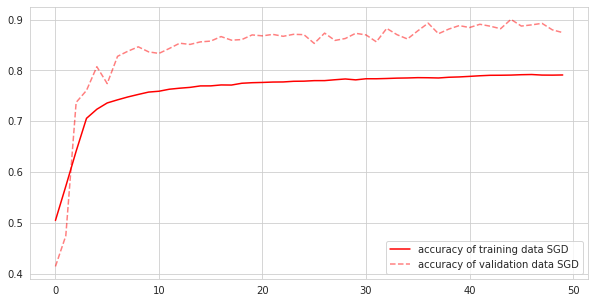

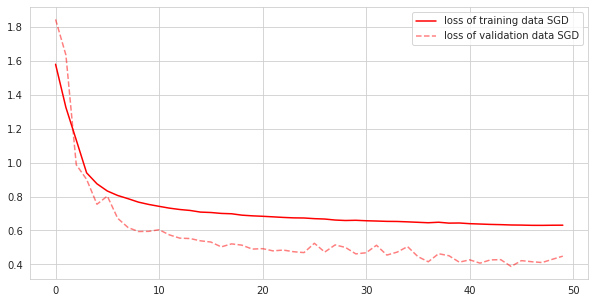

In [45]:
plt.rcParams['figure.figsize'] = [10, 5]
i=0
plt.plot(SGD_reglL1[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_reglL1[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL1[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_reglL1[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

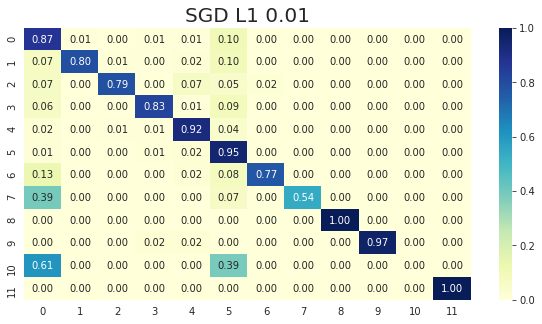

In [46]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_reglL1.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD L1 0.01', fontsize=20)
plt.show()

# L1  con $\lambda$ di 0.001

In [88]:
regl1 = regularizers.l1(0.001)
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_reglL1_1 = create_model_regl(opt, regl1, ini)

fit = model_reglL1_1.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_reglL1_1 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 323, 64)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 152, 16)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 2432)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 12)              

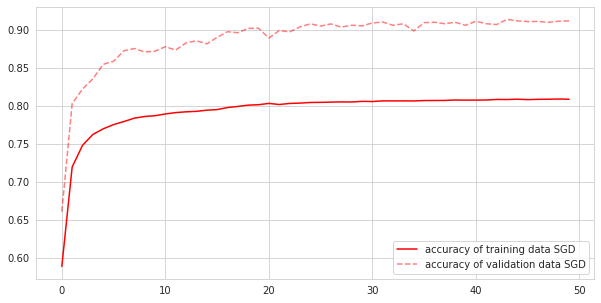

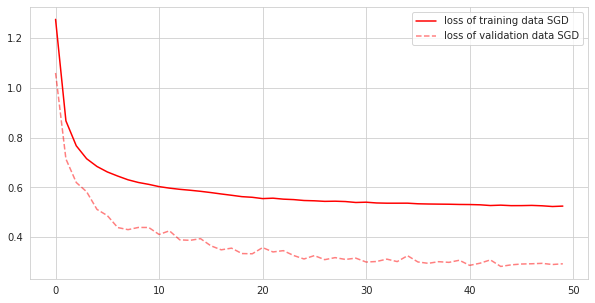

In [89]:
plt.rcParams['figure.figsize'] = [10, 5] 
i=0
plt.plot(SGD_reglL1_1[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_reglL1_1[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL1_1[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_reglL1_1[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()


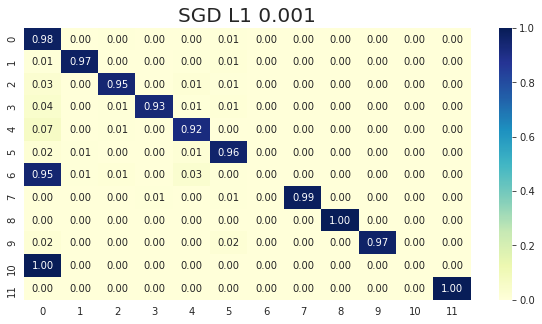

In [90]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_reglL1_1.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD L1 0.001', fontsize=20)
plt.show()

# L1  con $\lambda$ di  0.02

In [52]:
regl1 = regularizers.l1(0.02)
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_reglL1_2 = create_model_regl(opt, regl1, ini)

fit = model_reglL1_2.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_reglL1_2 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 323, 64)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 152, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)               

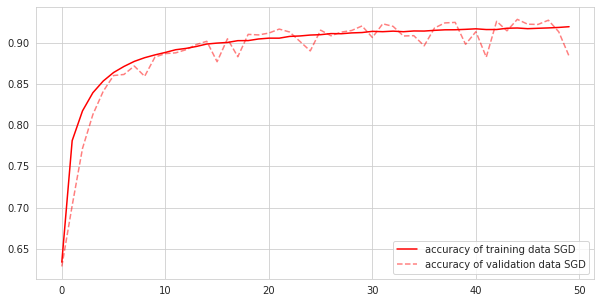

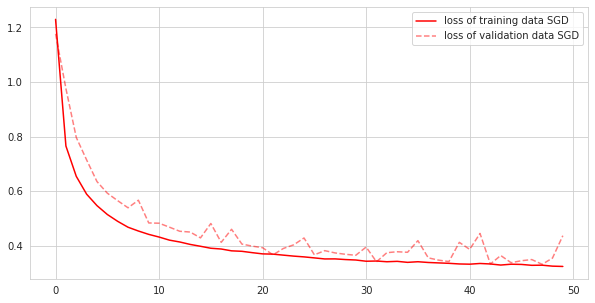

In [53]:
plt.rcParams['figure.figsize'] = [10, 5]  
i=0
plt.plot(SGD_reglL1_2[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_reglL1_2[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL1_2[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_reglL1_2[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

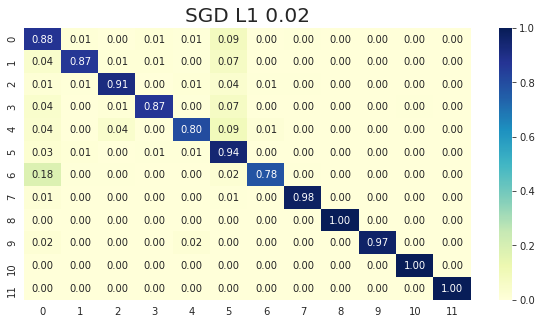

In [54]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_reglL1_2.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD L1 0.02', fontsize=20)
plt.show()

# L1 con $\lambda$ di 0.005

In [85]:
regl1 = regularizers.l1(0.005)
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_reglL1_3 = create_model_regl(opt, regl1, ini)

fit = model_reglL1_3.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_reglL1_3 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 323, 64)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 152, 16)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2432)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 12)              

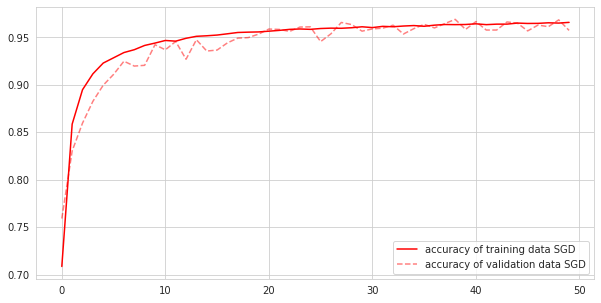

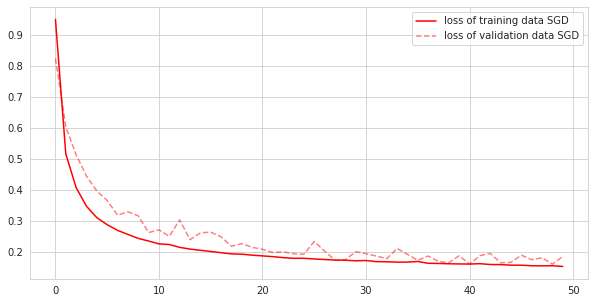

In [86]:
plt.rcParams['figure.figsize'] = [10, 5] 
i=0
plt.plot(SGD_reglL1_3[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_reglL1_3[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL1_3[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_reglL1_3[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

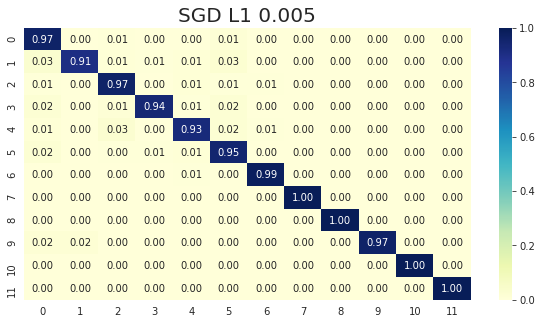

In [87]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_reglL1_3.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD L1 0.005', fontsize=20)
plt.show()

# L2  con $\lambda$ di  0.01

In [60]:
regl2 = regularizers.l2(0.01)
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_reglL2 = create_model_regl(opt, regl2, ini)

fit = model_reglL2.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_reglL2 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 152, 16)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)               

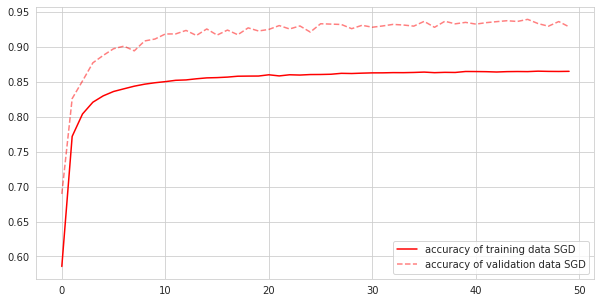

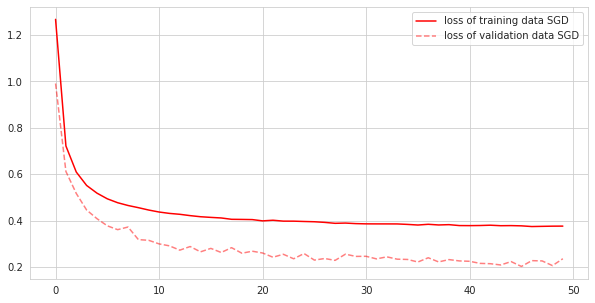

In [61]:
plt.rcParams['figure.figsize'] = [10, 5] 
i=0
plt.plot(SGD_reglL2[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_reglL2[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL2[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_reglL2[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

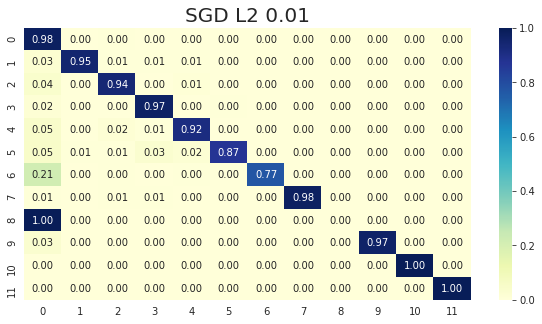

In [62]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_reglL2.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD L2 0.01', fontsize=20)
plt.show()

# L2 con $\lambda$ di 0.001

In [63]:
regl2 = regularizers.l2(0.001)
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_reglL2_1 = create_model_regl(opt, regl2, ini)

fit = model_reglL2_1.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_reglL2_1 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 152, 16)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)               

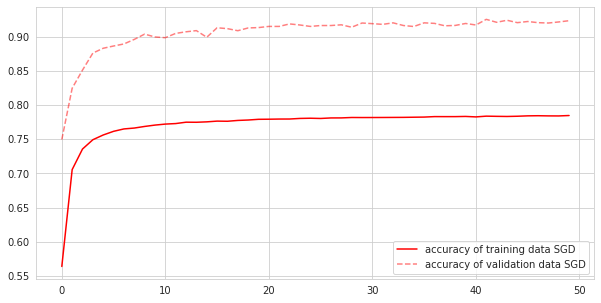

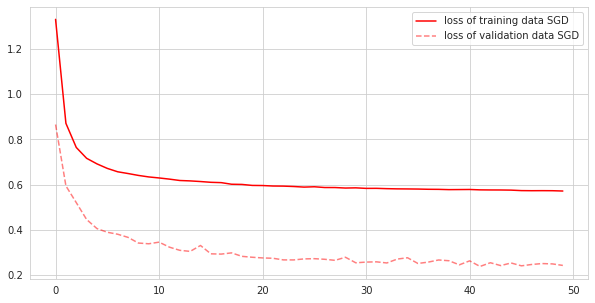

In [64]:
plt.rcParams['figure.figsize'] = [10, 5]  
i=0
plt.plot(SGD_reglL2_1[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_reglL2_1[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL2_1[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_reglL2_1[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

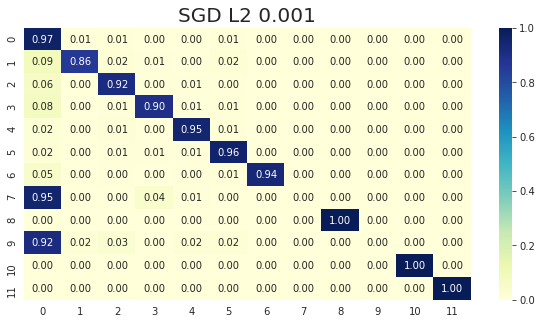

In [65]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_reglL2_1.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD L2 0.001', fontsize=20)
plt.show()

# L2 con $\lambda$ di 0.02

In [66]:
regl2 = regularizers.l2(0.02)
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_reglL2_2 = create_model_regl(opt, regl2, ini)

fit = model_reglL2_2.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_reglL2_2 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 152, 16)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 12)               

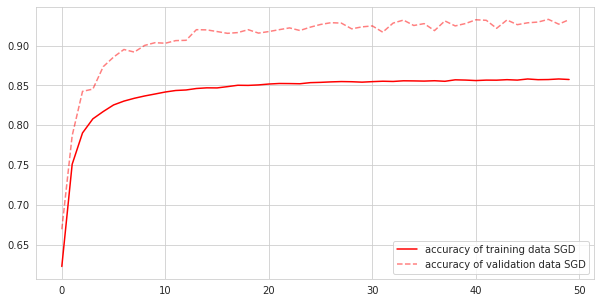

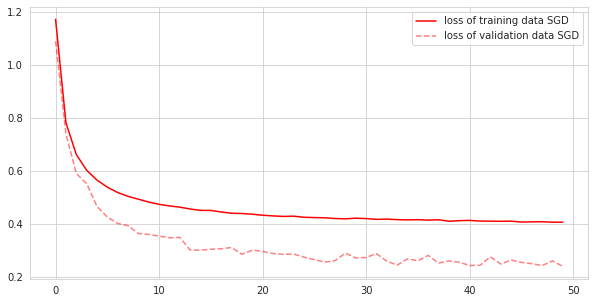

In [67]:
plt.rcParams['figure.figsize'] = [10, 5]  
i=0
plt.plot(SGD_reglL2_2[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_reglL2_2[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL2_2[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_reglL2_2[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

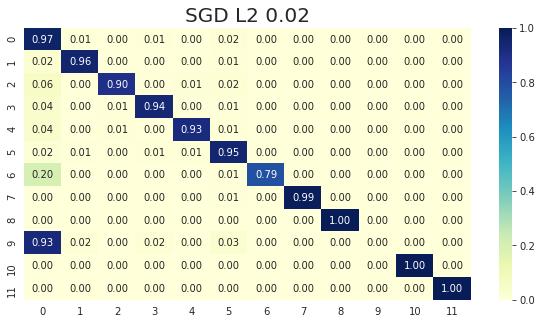

In [68]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_reglL2_2.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD L2 0.02', fontsize=20)
plt.show()

# L2  con $\lambda$ di 0.005

In [69]:
regl2 = regularizers.l2(0.005)
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_reglL2_3 = create_model_regl(opt, regl2, ini)

fit = model_reglL2_3.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_reglL2_3 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 323, 64)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 152, 16)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)               

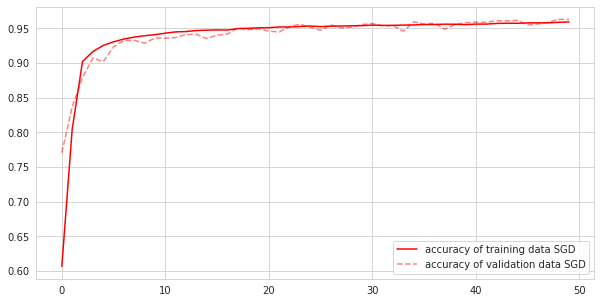

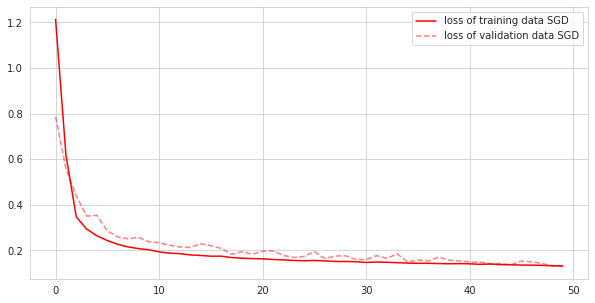

In [70]:
plt.rcParams['figure.figsize'] = [10, 5]  
i=0
plt.plot(SGD_reglL2_3[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_reglL2_3[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL2_3[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_reglL2_3[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

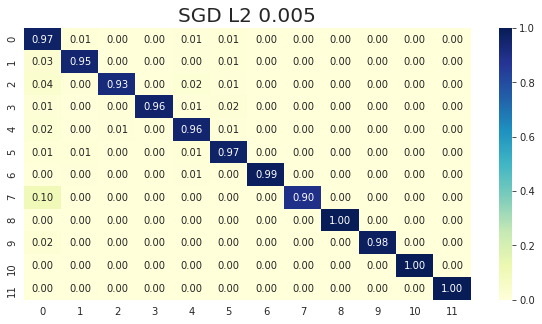

In [71]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_reglL2_3.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD L2 0.005', fontsize=20)
plt.show()

# Senza regolarizzazione

In [73]:
def create_model_diminuito2(optimizer, activation='relu'):
    model = Sequential()
    model.add(Conv1D(64, 5, strides=1, input_shape = input_shape, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 20, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(12, activation = activation))
    model.add(Softmax())

    print(model.summary())

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [76]:
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model_noreg = create_model_diminuito2(opt)

fit = model_noreg.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD_noreg = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 323, 64)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 323, 64)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 304, 16)           20496     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 152, 16)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2432)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)              

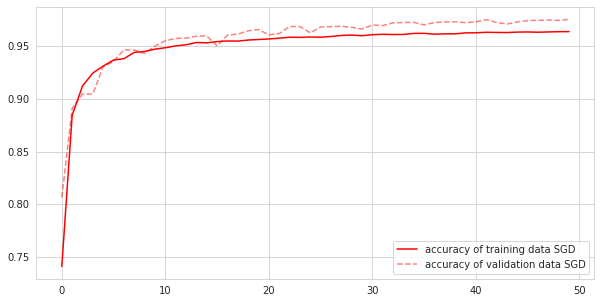

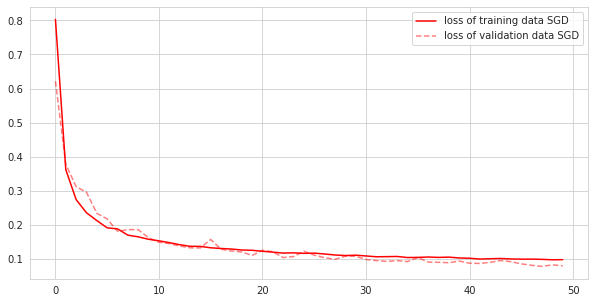

In [77]:
plt.rcParams['figure.figsize'] = [10, 5]
i=0
plt.plot(SGD_noreg[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD_noreg[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD_noreg[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD_noreg[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

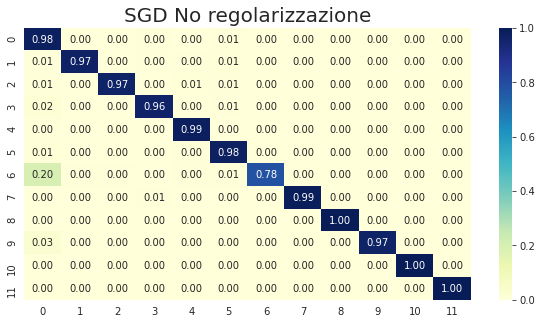

In [78]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model_noreg.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD No regolarizzazione', fontsize=20)
plt.show()

# Grafici regolarizzazione

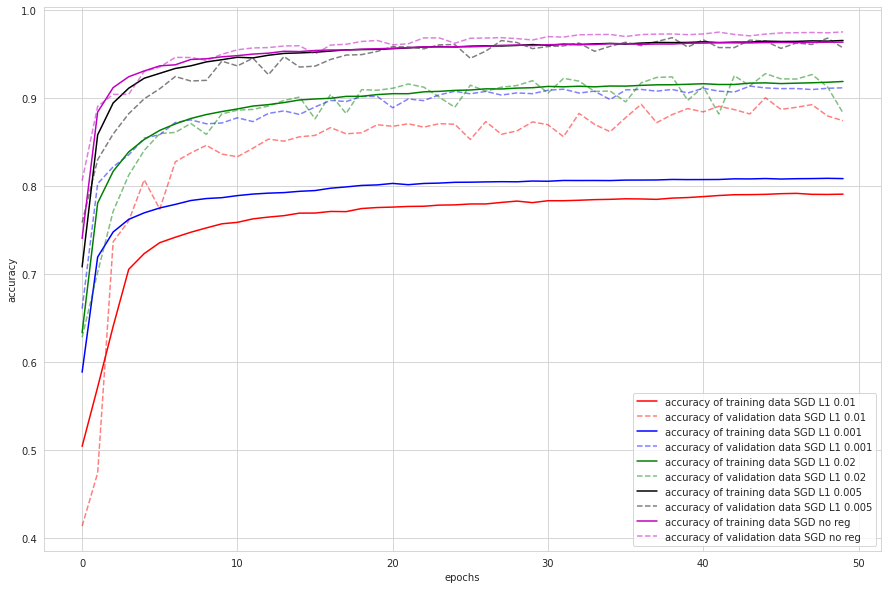

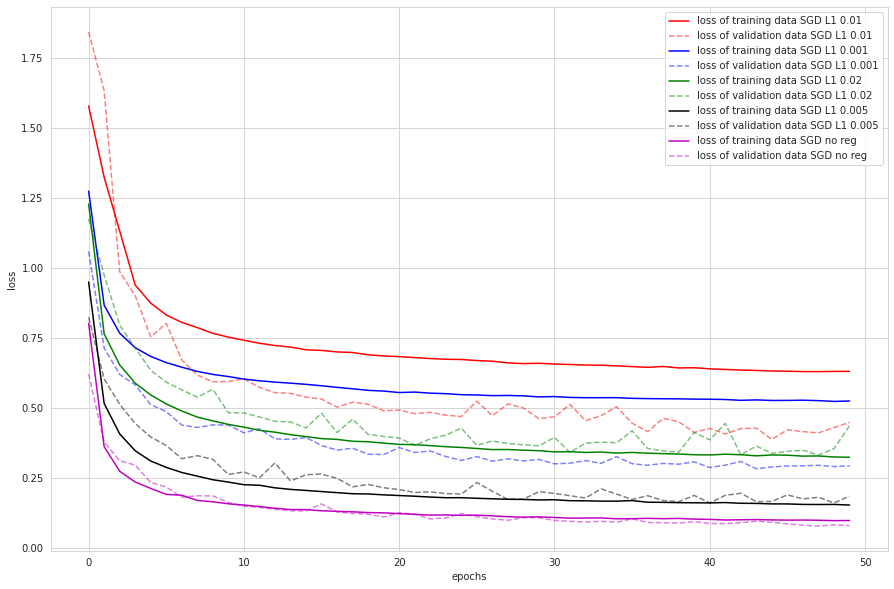

In [91]:
plt.rcParams['figure.figsize'] = [15, 10] 
i=0
plt.plot(SGD_reglL1[i], 'r', label = 'accuracy of training data SGD L1 0.01')
plt.plot(SGD_reglL1[i+1], 'r--', label = 'accuracy of validation data SGD L1 0.01', alpha=0.5)

plt.plot(SGD_reglL1_1[i], 'b', label = 'accuracy of training data SGD L1 0.001')
plt.plot(SGD_reglL1_1[i+1], 'b--', label = 'accuracy of validation data SGD L1 0.001', alpha=0.5)

plt.plot(SGD_reglL1_2[i], 'g', label = 'accuracy of training data SGD L1 0.02')
plt.plot(SGD_reglL1_2[i+1], 'g--', label = 'accuracy of validation data SGD L1 0.02', alpha=0.5)

plt.plot(SGD_reglL1_3[i], 'k', label = 'accuracy of training data SGD L1 0.005')
plt.plot(SGD_reglL1_3[i+1], 'k--', label = 'accuracy of validation data SGD L1 0.005', alpha=0.5)

plt.plot(SGD_noreg[i], 'm', label = 'accuracy of training data SGD no reg')
plt.plot(SGD_noreg[i+1], 'm--', label = 'accuracy of validation data SGD no reg', alpha=0.5)
plt.legend() 
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

i=2
plt.plot(SGD_reglL1[i], 'r', label = 'loss of training data SGD L1 0.01')
plt.plot(SGD_reglL1[i+1], 'r--', label = 'loss of validation data SGD L1 0.01', alpha=0.5)

plt.plot(SGD_reglL1_1[i], 'b', label = 'loss of training data SGD L1 0.001')
plt.plot(SGD_reglL1_1[i+1], 'b--', label = 'loss of validation data SGD L1 0.001', alpha=0.5)

plt.plot(SGD_reglL1_2[i], 'g', label = 'loss of training data SGD L1 0.02')
plt.plot(SGD_reglL1_2[i+1], 'g--', label = 'loss of validation data SGD L1 0.02', alpha=0.5)

plt.plot(SGD_reglL1_3[i], 'k', label = 'loss of training data SGD L1 0.005')
plt.plot(SGD_reglL1_3[i+1], 'k--', label = 'loss of validation data SGD L1 0.005', alpha=0.5)

plt.plot(SGD_noreg[i], 'm', label = 'loss of training data SGD no reg')
plt.plot(SGD_noreg[i+1], 'm--', label = 'loss of validation data SGD no reg', alpha=0.5)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.show()

Dai grafici ottenuti si osserva che i risultati migliori si ottengono per la traccia viola (senza regolarizzazione), quella nera ($\lambda = 0.005$) e infine per quella verde ($\lambda = 0.02$)

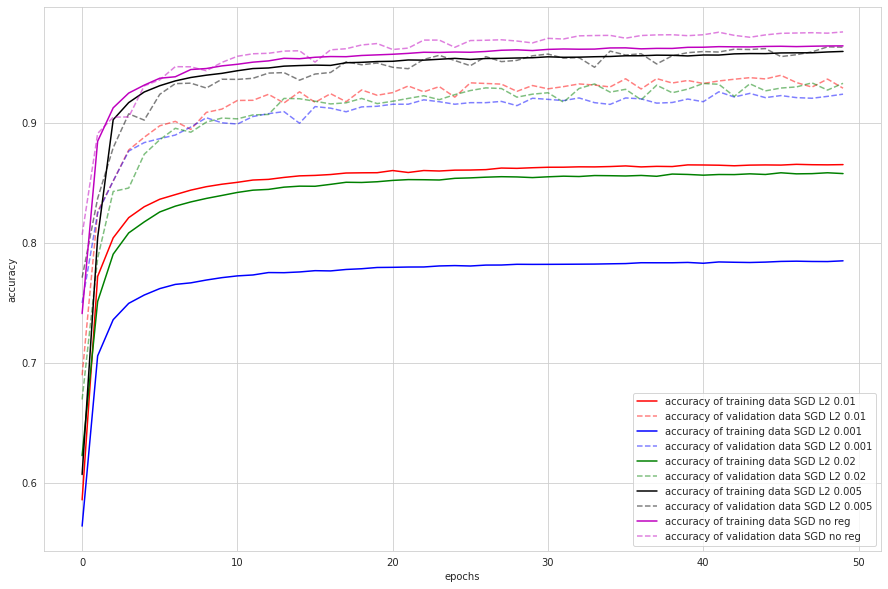

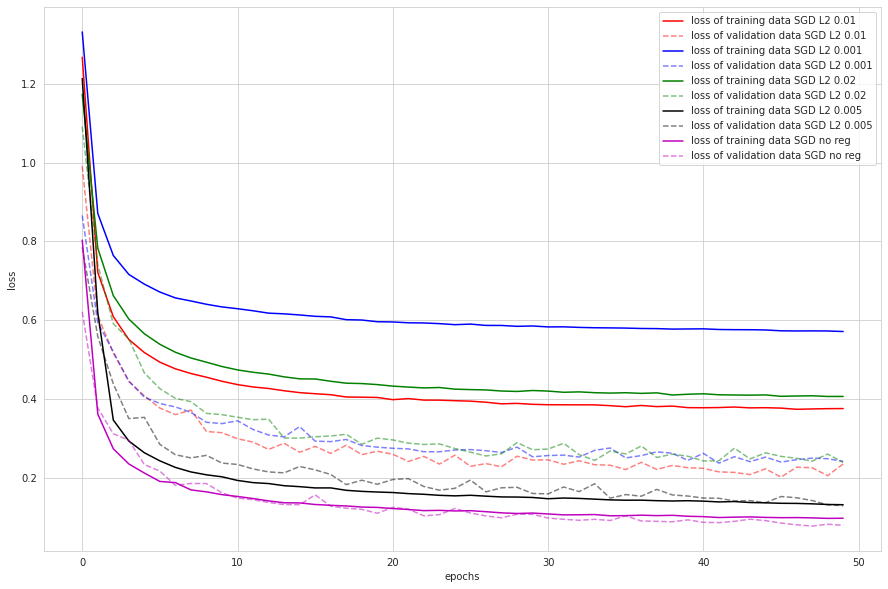

In [92]:
plt.rcParams['figure.figsize'] = [15, 10] 
i=0
plt.plot(SGD_reglL2[i], 'r', label = 'accuracy of training data SGD L2 0.01')
plt.plot(SGD_reglL2[i+1], 'r--', label = 'accuracy of validation data SGD L2 0.01', alpha=0.5)

plt.plot(SGD_reglL2_1[i], 'b', label = 'accuracy of training data SGD L2 0.001')
plt.plot(SGD_reglL2_1[i+1], 'b--', label = 'accuracy of validation data SGD L2 0.001', alpha=0.5)

plt.plot(SGD_reglL2_2[i], 'g', label = 'accuracy of training data SGD L2 0.02')
plt.plot(SGD_reglL2_2[i+1], 'g--', label = 'accuracy of validation data SGD L2 0.02', alpha=0.5)

plt.plot(SGD_reglL2_3[i], 'k', label = 'accuracy of training data SGD L2 0.005')
plt.plot(SGD_reglL2_3[i+1], 'k--', label = 'accuracy of validation data SGD L2 0.005', alpha=0.5)

plt.plot(SGD_noreg[i], 'm', label = 'accuracy of training data SGD no reg')
plt.plot(SGD_noreg[i+1], 'm--', label = 'accuracy of validation data SGD no reg', alpha=0.5)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend() 
plt.show()

i=2
plt.plot(SGD_reglL2[i], 'r', label = 'loss of training data SGD L2 0.01')
plt.plot(SGD_reglL2[i+1], 'r--', label = 'loss of validation data SGD L2 0.01', alpha=0.5)

plt.plot(SGD_reglL2_1[i], 'b', label = 'loss of training data SGD L2 0.001')
plt.plot(SGD_reglL2_1[i+1], 'b--', label = 'loss of validation data SGD L2 0.001', alpha=0.5)

plt.plot(SGD_reglL2_2[i], 'g', label = 'loss of training data SGD L2 0.02')
plt.plot(SGD_reglL2_2[i+1], 'g--', label = 'loss of validation data SGD L2 0.02', alpha=0.5)

plt.plot(SGD_reglL2_3[i], 'k', label = 'loss of training data SGD L2 0.005')
plt.plot(SGD_reglL2_3[i+1], 'k--', label = 'loss of validation data SGD L2 0.005', alpha=0.5)

plt.plot(SGD_noreg[i], 'm', label = 'loss of training data SGD no reg')
plt.plot(SGD_noreg[i+1], 'm--', label = 'loss of validation data SGD no reg', alpha=0.5)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.show()

Nella regolarizzazione L2 vediamo che i tracciati migliori risultano quelli viola e neri: rispettivamente senza regressione e con $\lambda = 0.005$

# Calcolo parametri della confusion matrix
Per valutare i modelli utilizzati si sono considerate le grandezze ricavabili dalla confusion matrix: l'accuratezza, la precisione, la sensibilità e lo score F1. In particolare vediamo quantità micro, macro e weithed. le micro corrispondono alle grandezze calcolate per ogni classe senza alcuna media. Le macro calcolano le metriche per ogni classe individualmente e quindi prende la media non ponderata delle misure. Le weithed fanno anche la media ponderata.

### No regolarizzazione

In [93]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_noreg.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.97

Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-score: 0.97

Macro Precision: 0.96
Macro Recall: 0.97
Macro F1-score: 0.96

Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97


### L1 0.01

In [94]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_reglL1.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.87

Micro Precision: 0.87
Micro Recall: 0.87
Micro F1-score: 0.87

Macro Precision: 0.83
Macro Recall: 0.79
Macro F1-score: 0.80

Weighted Precision: 0.88
Weighted Recall: 0.87
Weighted F1-score: 0.87


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### L1 0.001

In [95]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_reglL1_1.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.78
Macro Recall: 0.81
Macro F1-score: 0.79

Weighted Precision: 0.88
Weighted Recall: 0.90
Weighted F1-score: 0.89


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### L1 0.02

In [96]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_reglL1_2.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.88

Micro Precision: 0.88
Micro Recall: 0.88
Micro F1-score: 0.88

Macro Precision: 0.86
Macro Recall: 0.92
Macro F1-score: 0.88

Weighted Precision: 0.89
Weighted Recall: 0.88
Weighted F1-score: 0.88


### L1 0.005

In [97]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_reglL1_3.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.94
Macro Recall: 0.97
Macro F1-score: 0.95

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95


### L2 0.01

In [98]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_reglL2.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92

Macro Precision: 0.83
Macro Recall: 0.86
Macro F1-score: 0.84

Weighted Precision: 0.92
Weighted Recall: 0.92
Weighted F1-score: 0.91


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### L2 0.001

In [99]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_reglL2_1.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92

Macro Precision: 0.78
Macro Recall: 0.79
Macro F1-score: 0.78

Weighted Precision: 0.91
Weighted Recall: 0.92
Weighted F1-score: 0.91


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### L2 0.02

In [100]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_reglL2_2.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.85
Macro Recall: 0.87
Macro F1-score: 0.85

Weighted Precision: 0.93
Weighted Recall: 0.93
Weighted F1-score: 0.93


### L2 0.005

In [101]:
 #importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_test = Ytest.astype(int)
y_pred  = np.argmax(model_reglL2_3.predict(test.astype(float)), axis=-1)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.96

Micro Precision: 0.96
Micro Recall: 0.96
Micro F1-score: 0.96

Macro Precision: 0.96
Macro Recall: 0.97
Macro F1-score: 0.96

Weighted Precision: 0.96
Weighted Recall: 0.96
Weighted F1-score: 0.96
